<b>The point of this project is to create a heat map of the median selling price per square foot of real estate in Washington state by zip code (and a YoY growth rate of this metric) using data from Zillow on real estate selling prices and the lat/lon mapping data is from federalgovernmentzipcodes.us

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
sales_data = pd.read_csv('Zip_MedianListingPricePerSqft_AllHomes.csv')
zip_code_data = pd.read_csv('free-zipcode-database-Primary.csv')

In [3]:
wa_sales_data = pd.DataFrame(sales_data[sales_data["State"]=="WA"])
wa_sales_data.reset_index(inplace=True,drop=True)

There are over 700 zip codes in Washington state so it is clear that we are missing a significant amount of data but my assumption is that most of the missing zip codes are from sparsely populated areas, we will have a better idea after the map is built 

In [4]:
len(wa_sales_data)

284

In [5]:
#basic info about the most recent month
wa_sales_data["2016-05"].describe()

count    284.000000
mean     198.711039
std       93.959080
min       59.588165
25%      142.681078
50%      170.292515
75%      218.295507
max      734.135021
Name: 2016-05, dtype: float64

In [6]:
#visually what the data looks like
wa_sales_data.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,...,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05
0,98052,Redmond,WA,Seattle,King,101,247.724215,244.422222,244.526587,239.941926,...,287.644860,289.334175,291.497420,293.351372,294.450736,298.824987,312.500000,305.853621,304.308786,312.472192
1,98103,Seattle,WA,Seattle,King,183,303.578725,302.162162,308.950086,309.999433,...,390.426571,389.784946,391.705069,391.705069,394.703947,406.474820,398.872683,407.801418,419.203414,419.098914
2,98012,Bothell,WA,Seattle,Snohomish,209,174.816434,173.239824,173.554493,173.520750,...,201.039114,201.065840,202.370212,203.732665,203.229699,205.253061,207.118644,211.184211,213.067708,214.715000
3,99301,Pasco,WA,Kennewick,Franklin,212,101.902037,103.328321,103.760446,106.513133,...,117.581602,117.913832,118.315415,119.307286,121.317276,121.869565,121.191176,123.003884,121.788746,121.745277
4,98133,Shoreline,WA,Seattle,King,355,218.454404,217.279213,223.938356,224.273875,...,252.380952,255.178954,255.070400,250.584795,257.575758,270.758123,266.868392,271.804723,272.701705,276.668729


In [133]:
#adding a column for the most recent Jan YoY growth rate
wa_sales_data["growth"] = ((wa_sales_data["2016-01"] - wa_sales_data["2015-01"])/wa_sales_data["2015-01"])

In [134]:
#merge the data on zip code to get a combined data set with lat/lon
com_data = pd.merge(wa_sales_data,zip_code_data[["Zipcode","Lat","Long"]],\
                    left_on="RegionName",right_on="Zipcode")

In [102]:
#ensure the data has the necessary columns
com_data.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,...,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,growth,Zipcode,Lat,Long
0,98052,Redmond,WA,Seattle,King,101,247.724215,244.422222,244.526587,239.941926,...,294.450736,298.824987,312.500000,305.853621,304.308786,312.472192,0.206281,98052,47.68,-122.12
1,98103,Seattle,WA,Seattle,King,183,303.578725,302.162162,308.950086,309.999433,...,394.703947,406.474820,398.872683,407.801418,419.203414,419.098914,0.338944,98103,47.67,-122.34
2,98012,Bothell,WA,Seattle,Snohomish,209,174.816434,173.239824,173.554493,173.520750,...,203.229699,205.253061,207.118644,211.184211,213.067708,214.715000,0.174106,98012,47.84,-122.19
3,99301,Pasco,WA,Kennewick,Franklin,212,101.902037,103.328321,103.760446,106.513133,...,121.317276,121.869565,121.191176,123.003884,121.788746,121.745277,0.195948,99301,46.41,-118.90
4,98133,Shoreline,WA,Seattle,King,355,218.454404,217.279213,223.938356,224.273875,...,257.575758,270.758123,266.868392,271.804723,272.701705,276.668729,0.239426,98133,47.73,-122.34


This is where we will start plotting, using Basemap. The map is first built using the bottom left, and top right corner in lat/lon to define the desired area, some additional features are added (coastlines, countries, etc...). Then for each row in the data set we convert the lat/lon to usable data for Basemap and append this data, along with the metric of interest (here it is median selling price per square foot) to the respective list which is then passed to the .scatter function of our map, and plotted.

NOTE: the 'f' resolution is full, and will take a long time to load for larger maps, use 'l' for low if looking at large maps

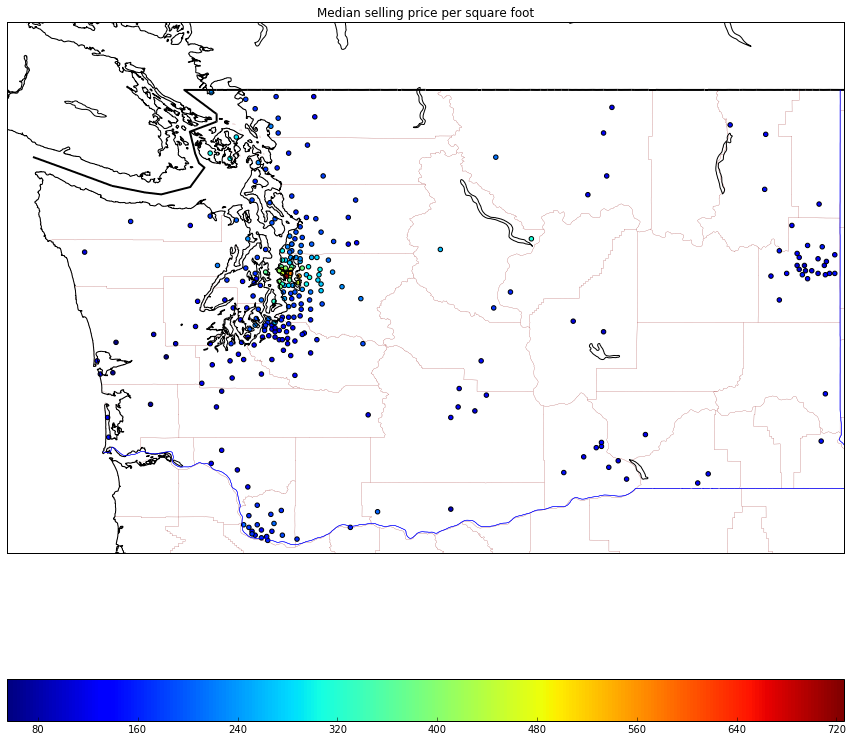

In [173]:
plt.figure(figsize=(15,15))
m = Basemap(projection='mill', 
            llcrnrlat = 45.5,
            llcrnrlon = -125, 
            urcrnrlat = 49.5,
            urcrnrlon = -117
            ,resolution='f')


m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')
m.drawcounties(color='darkred')

xs = []
ys = []
z = []


for i in com_data.index:
    xpt, ypt = m(com_data.ix[i]["Long"], com_data.ix[i]["Lat"])
    xs.append(xpt)
    ys.append(ypt)
    z.append(com_data.ix[i]["2016-01"])

    


m.scatter(xs, ys, c=z)
c = plt.colorbar(orientation='horizontal')

plt.title("Median selling price per square foot")
plt.show()

This is the same graph, done the same way but showing the Jan YoY growth of the median selling price per square foot. This shows significantly more variation which is likely due to the inherent normalization of a percent increase. Seattle still dominates but there are noticable differences in neighboring zip codes that are outside of King County.

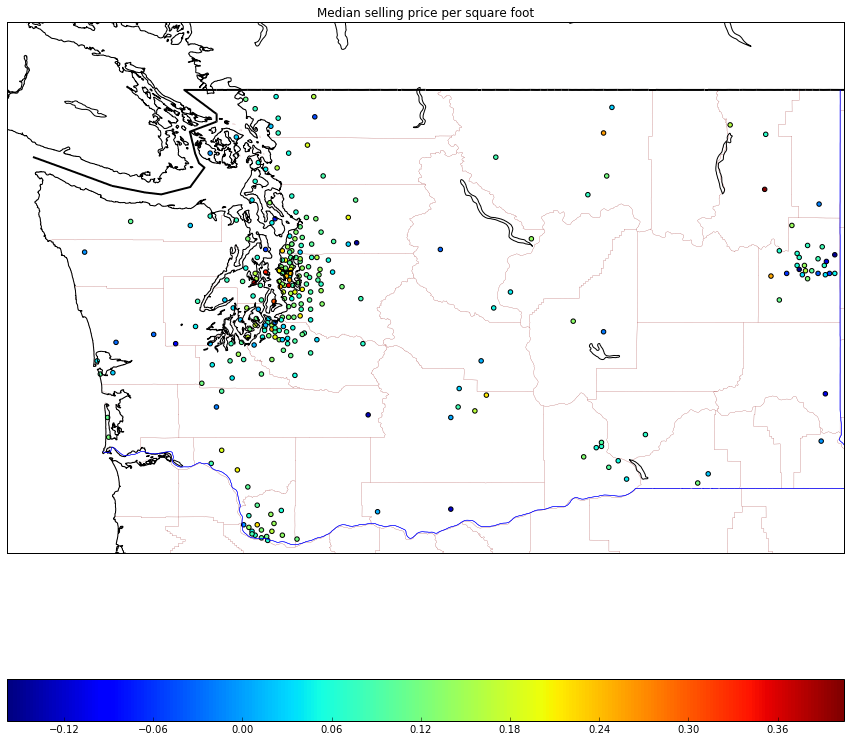

In [174]:
plt.figure(figsize=(15,15))
m = Basemap(projection='mill', 
            llcrnrlat = 45.5,
            llcrnrlon = -125, 
            urcrnrlat = 49.5,
            urcrnrlon = -117
            ,resolution='f')


m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')
m.drawcounties(color='darkred')

xs = []
ys = []
z = []


for i in com_data.index:
    xpt, ypt = m(com_data.ix[i]["Long"], com_data.ix[i]["Lat"])
    xs.append(xpt)
    ys.append(ypt)
    z.append(com_data.ix[i]["growth"])

    


m.scatter(xs, ys, c=z)
c = plt.colorbar(orientation='horizontal')

plt.title("Median selling price per square foot")
plt.show()